<a href="https://www.kaggle.com/code/dlbkvv/exam-ships-segmentation?scriptVersionId=178756129" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [51]:
!pip install -q segmentation-models-pytorch

In [52]:
!pip install -q torchsummary

In [53]:
import numpy as np 
import pandas as pd 
import torch
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torchsummary import summary
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch import Unet
import torchmetrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
device

'cuda'

In [55]:
df = pd.read_csv('/kaggle/input/itstep-exam2/ship_segmentations.csv')
img_dir = '/kaggle/input/itstep-exam2/ship_images'

In [56]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [57]:
df.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,ad5092ca2.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [59]:
count_ships_df = df.groupby('ImageId').count()
count_ships_df

,EncodedPixels
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,1
000194a2d.jpg,5
0001b1832.jpg,0
...,...
fffedbb6b.jpg,0
ffff2aa57.jpg,0
ffff6e525.jpg,0


In [60]:
count_img_to_ships = {}
max_ships_img = count_ships_df['EncodedPixels'].max()
for i in range(0, max_ships_img +1):
    temp_count = count_ships_df[count_ships_df['EncodedPixels'] == i].count().iloc[0]
    count_img_to_ships[i] = temp_count

count_img_to_ships = pd.DataFrame(list(count_img_to_ships.items()), columns=['ShipCount', 'ImageCount'])
count_img_to_ships

,ShipCount,ImageCount
0,0,150000
1,1,27104
2,2,7674
3,3,2954
4,4,1622
5,5,925
6,6,657
7,7,406
8,8,318
9,9,243


In [61]:
total_img_with_ships = count_img_to_ships['ImageCount'].sum() - 150_000
total_img_with_ships

42556

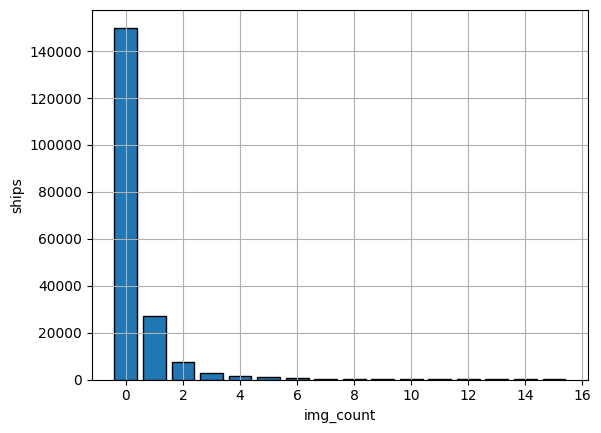

In [62]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.grid(True)
plt.show()

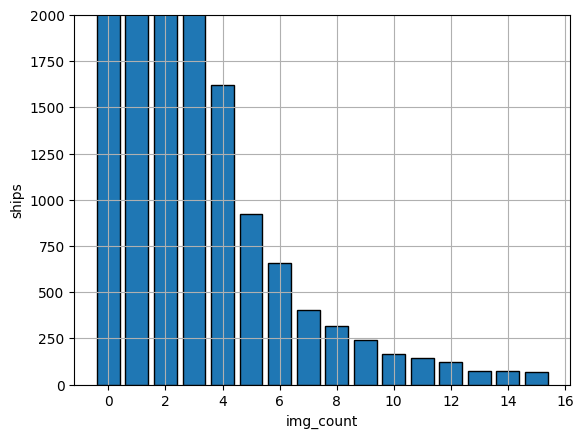

In [63]:

plt.bar(count_img_to_ships['ShipCount'], count_img_to_ships['ImageCount'], edgecolor='black')
plt.xlabel('img_count')
plt.ylabel('ships')
plt.ylim(0, 2000)
plt.grid(True)
plt.show()

In [64]:
wout_ships = df[df['EncodedPixels'].isna()]
with_ships = df[df['EncodedPixels'].notna()]

reduced_wout_ships = wout_ships.sample(500) 

balanced_df = pd.concat([with_ships, reduced_wout_ships])
balanced_df

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
185388,cccc7e0f4.jpg,NaN
182180,c9308cbb1.jpg,NaN
195957,d89f69b3f.jpg,NaN
103940,72928ec50.jpg,NaN


In [65]:
balanced_df['EncodedPixels'] = balanced_df['EncodedPixels'].astype(str)

In [66]:
balanced_grouped = balanced_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()
balanced_grouped

,ImageId,EncodedPixels
0,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...
1,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...
2,00021ddc3.jpg,[108287 1 109054 3 109821 4 110588 5 111356 5 ...
3,0002756f7.jpg,[255784 2 256552 4 257319 7 258087 9 258854 12...
4,00031f145.jpg,[340363 1 341129 4 341896 6 342663 7 343429 10...
...,...,...
43051,fff909871.jpg,[441057 2 441825 4 442592 7 443360 9 444128 11...
43052,fffcb6464.jpg,[222782 4 223550 10 224318 14 225086 14 225854...
43053,fffd924fb.jpg,[110011 5 110779 5 111547 5 112315 5 113083 5 ...
43054,fffdd2377.jpg,[333603 7 334359 19 335120 26 335888 26 336656...


In [67]:
grouped = balanced_grouped.groupby(balanced_grouped['EncodedPixels'].apply(lambda x: x == ['nan']))

nan_group = grouped.filter(lambda x: x['EncodedPixels'].iloc[0] == ['nan'])
not_nan_group = grouped.filter(lambda x: x['EncodedPixels'].iloc[0] != ['nan'])

reduced_not_nan_group = not_nan_group.sample(1500)

rebalanced_grouped = pd.concat([reduced_not_nan_group, nan_group])
rebalanced_grouped

,ImageId,EncodedPixels
3177,12bb9349b.jpg,[25902 3 26670 7 27438 11 28205 17 28973 21 29...
1270,07d1b4687.jpg,[449669 15 450409 43 451163 57 451931 57 45269...
7088,2a3e5fe2b.jpg,[119608 2 120373 5 121139 8 121904 11 122669 1...
16936,6476a2b7a.jpg,[378475 1 379241 4 380008 5 380774 8 381540 10...
26342,9c94694cd.jpg,[425868 5 426636 9 427404 9 428172 9 428940 9 ...
...,...,...
42667,fdbfc9069.jpg,[nan]
42774,fe64679a1.jpg,[nan]
43006,ffb842f24.jpg,[nan]
43028,ffd75fe4c.jpg,[nan]


In [68]:
class ShipDataset(Dataset):
    def __init__(self, df, image_dir, image_shape=(768,768), transform=None, preprocessing_fn=None):
        self.df = df
        self.image_dir = image_dir
        self.shape = image_shape
        self.transform = transform
        self.preprocessing_fn = preprocessing_fn
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['ImageId']
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        rles = self.df.iloc[idx]['EncodedPixels']
        mask = self.combine_rle_masks(rles, self.shape)

        if self.transform:
            image = self.transform(image)
        if self.preprocessing_fn:
            image = self.preprocessing_fn(np.array(image))
        
        return image, mask
    

    def rle_to_mask(self, rle, shape):
        """
        converting RLE string into a mask.

        Parameters:
        rle (str): rle string (format "start1 length1 start2 length2 ...")
        shape (tuple): mask shape (height, width)

        Returns:
        numpy.ndarray: mask as 2D numpy array
        """
            
        mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

        if rle == 'nan':
            return mask.reshape(shape)

        rle_nums = list(map(int, rle.split()))

        starts = rle_nums[0::2]
        lengths = rle_nums[1::2]

        starts = [start -1  for start in starts]

        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

        return mask.reshape(shape).T

    def combine_rle_masks(self, rles, shape):
        """
        Combines several RLE masks into one.

        Parameters:
        rles (list of str): list of rle strings
        shape (tuple): mask shape (height, width)

        Returns:
        torch.Tensor: combined mask as a 2D tensor
        """
        combined_mask = np.zeros(shape, dtype=np.uint8)

        for rle in rles:
            mask = self.rle_to_mask(rle, shape)
            combined_mask = np.maximum(combined_mask, mask)
            
        tensor_combined_mask = torch.tensor(combined_mask, dtype=torch.uint8)

        return tensor_combined_mask
    
   

In [69]:
visualize_dataset =  ShipDataset(df=rebalanced_grouped, image_dir=img_dir)

In [70]:
unique_image_ids = rebalanced_grouped['ImageId'].unique()

In [71]:
train_ids, test_ids = train_test_split(unique_image_ids, train_size=0.8, random_state=42)

train_df = rebalanced_grouped[rebalanced_grouped['ImageId'].isin(train_ids)]
test_df = rebalanced_grouped[rebalanced_grouped['ImageId'].isin(test_ids)]

train_grouped = train_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()
test_grouped = test_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()

train_grouped.columns = ['ImageId', 'EncodedPixels']
test_grouped.columns = ['ImageId', 'EncodedPixels']

In [72]:
#избавление от ненужной размерности
train_grouped['EncodedPixels'] = train_grouped['EncodedPixels'].apply(lambda x: [item for sublist in x for item in sublist])
test_grouped['EncodedPixels'] = test_grouped['EncodedPixels'].apply(lambda x: [item for sublist in x for item in sublist])

In [73]:
train_grouped['EncodedPixels'].iloc[6]

['293102 1 293868 3 294635 5 295401 7 296167 10 296934 12 297700 14 298467 16 299233 18 299999 21 300766 22 301532 25 302299 26 303068 26 303836 27 304605 26 305374 26 306142 26 306911 26 307679 26 308448 26 309217 26 309985 26 310754 26 311523 25 312291 26 313060 25 313829 25 314597 25 315366 25 316134 26 316903 25 317672 25 318440 25 319209 25 319978 24 320746 25 321515 24 322284 24 323052 25 323821 24 324589 25 325358 24 326127 24 326895 24 327664 1 327666 22 328435 21 328460 1 329203 22 329226 4 329972 26 330740 27 331509 27 332277 27 333046 27 333814 28 334583 27 335351 28 336120 28 336888 28 337656 29 338425 27 339194 24 339962 22 340731 20 341500 17 342268 15 343037 13 343805 11 344574 8 345343 6 346111 4 346880 1',
 '297745 2 298511 4 299278 6 300046 6 300815 6 301583 6 302352 6 303120 6 303889 6 304657 6 305426 6 306194 6 306963 6 307732 5 308500 3',
 '273914 1 274680 4 275446 6 276212 9 276979 10 277745 13 278511 15 279278 17 280044 19 280810 22 281576 25 282343 26 283112 26 

In [74]:
preprocess = get_preprocessing_fn('resnet18', pretrained='imagenet')

train_dataset = ShipDataset(df=train_grouped, image_dir=img_dir, preprocessing_fn=preprocess)
test_dataset = ShipDataset(df=test_grouped, image_dir=img_dir, preprocessing_fn=preprocess)


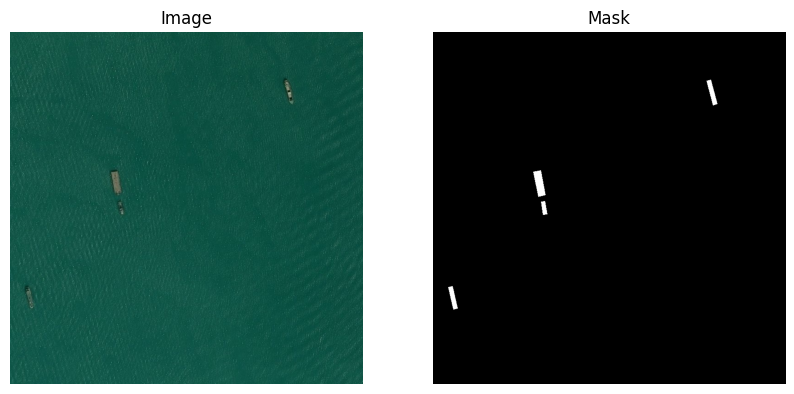

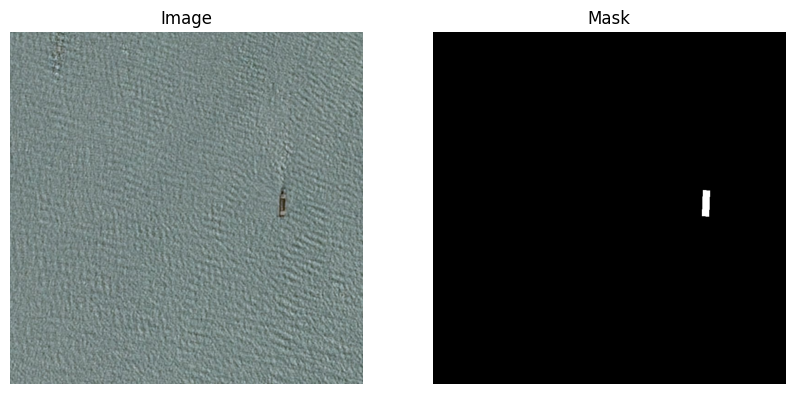

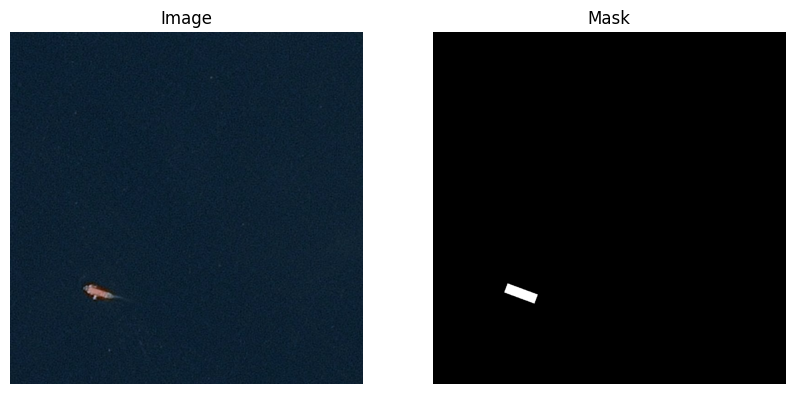

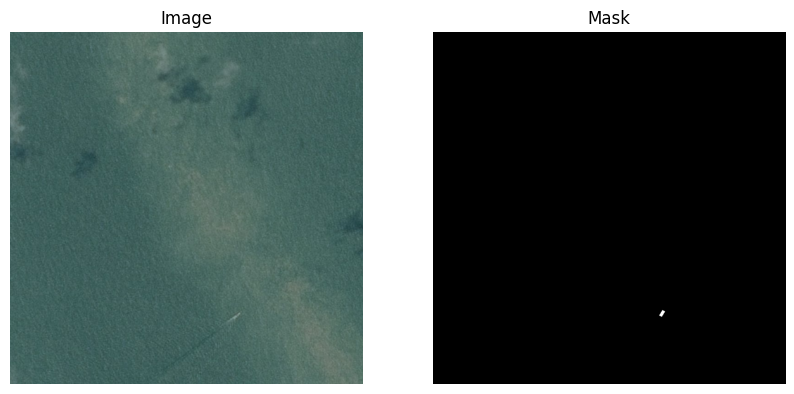

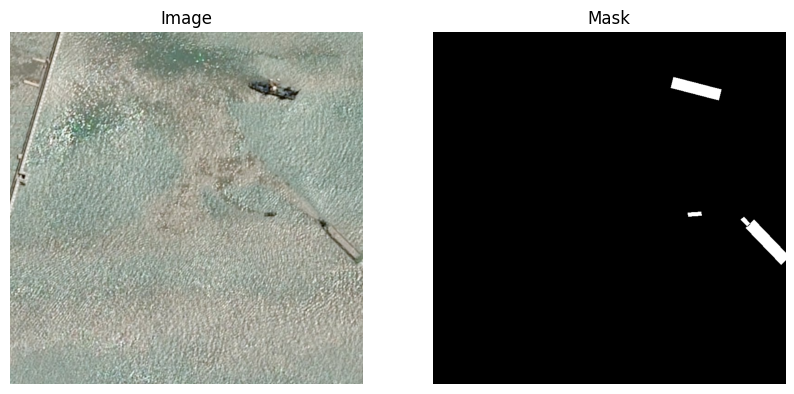

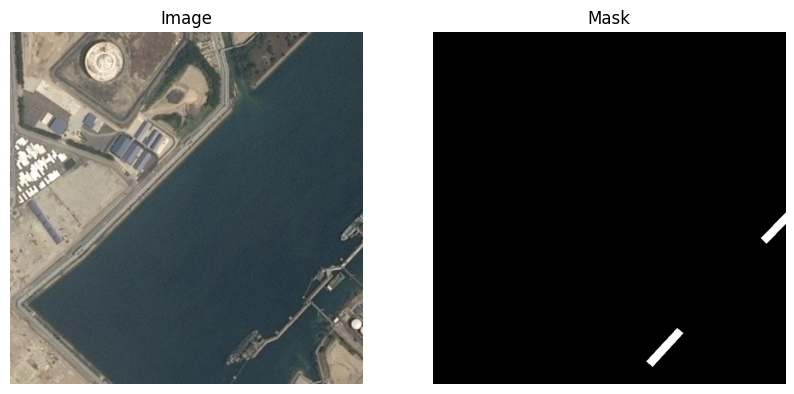

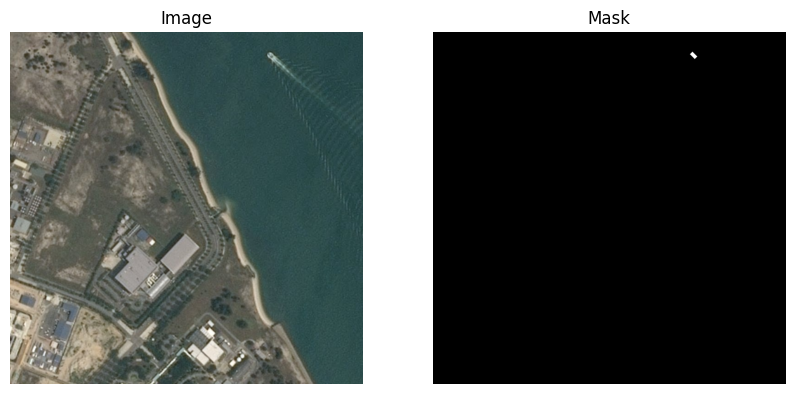

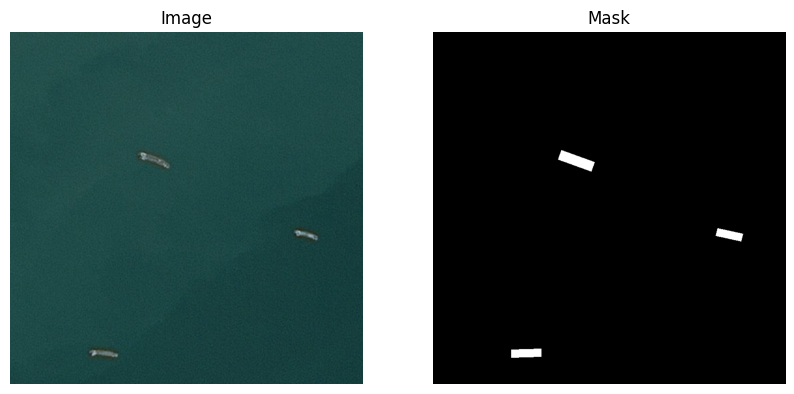

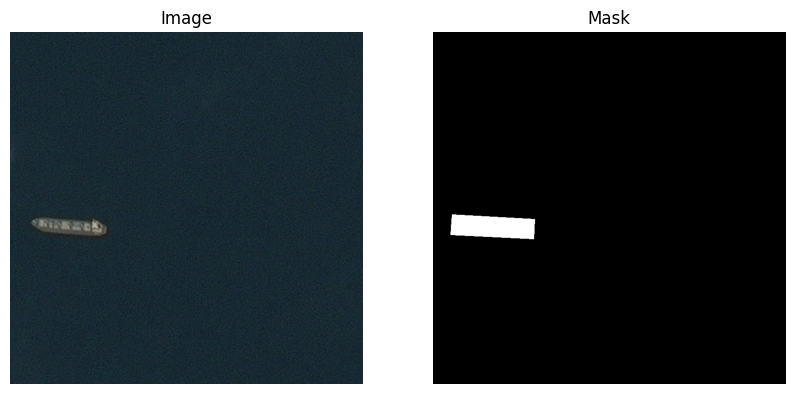

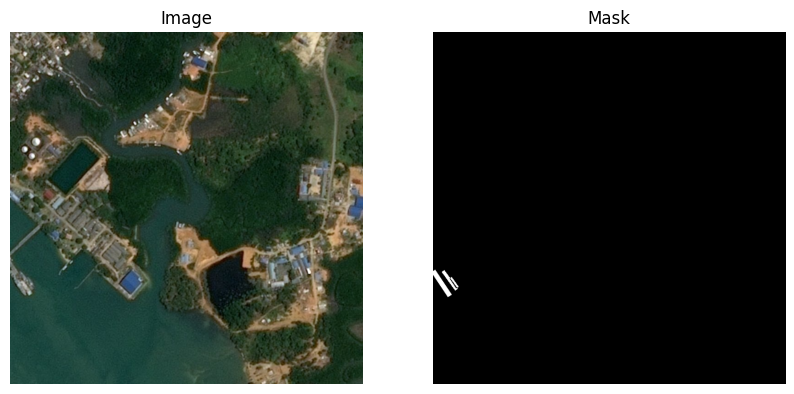

In [75]:
for i in range(10):
    image, mask = visualize_dataset[i]
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()

    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 2, 1)  
    plt.imshow(image)  
    plt.title("Image")  
    plt.axis("off")  
    
    plt.subplot(1, 2, 2)  
    plt.imshow(mask, cmap='gray')  
    plt.title("Mask")  
    plt.axis("off")  
    plt.show() 


In [76]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [77]:
model = Unet(encoder_name='resnet18', 
                      encoder_depth=5, 
                      encoder_weights='imagenet', 
                      decoder_channels=(256, 128, 64, 32, 16), 
                      decoder_use_batchnorm=True,
                      decoder_attention_type=None,
                      in_channels=3, 
                      classes=1, 
                      activation='sigmoid')

model = model.to(device)

for param in model.encoder.parameters():
    param.requires_grad = False

In [78]:
summary(model, input_size=(3, 768, 768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           9,408
       BatchNorm2d-2         [-1, 64, 384, 384]             128
              ReLU-3         [-1, 64, 384, 384]               0
         MaxPool2d-4         [-1, 64, 192, 192]               0
            Conv2d-5         [-1, 64, 192, 192]          36,864
       BatchNorm2d-6         [-1, 64, 192, 192]             128
              ReLU-7         [-1, 64, 192, 192]               0
            Conv2d-8         [-1, 64, 192, 192]          36,864
       BatchNorm2d-9         [-1, 64, 192, 192]             128
             ReLU-10         [-1, 64, 192, 192]               0
       BasicBlock-11         [-1, 64, 192, 192]               0
           Conv2d-12         [-1, 64, 192, 192]          36,864
      BatchNorm2d-13         [-1, 64, 192, 192]             128
             ReLU-14         [-1, 64, 1

In [79]:
# @title train function
import time

def train_segmentation(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cpu'):
    """
    Trains a segmentation model using Dice Loss and Recall as the evaluation metric.
    
    Parameters
    ----------
    model : nn.Module
        The segmentation model to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : nn.Module
        The loss function to use for training (DiceLoss).
    train_dl : DataLoader
        DataLoader for the training dataset.
    val_dl : DataLoader
        DataLoader for the validation dataset.
    epochs : int, optional
        Number of epochs to train the model. Default is 20.
    device : str, optional
        The device to use for training ('cpu' or 'cuda'). Default is 'cpu'.
    
    Returns
    -------
    dict
        Dictionary containing training and validation loss and recall for each epoch.
    """
    
    recall = torchmetrics.Recall(num_classes=1, threshold=0.5, task='binary').to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_recall': [],
        'val_recall': []
    }
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss = 0.0
        train_recall = 0.0
        
        for batch in train_dl:
            images, masks = batch
            images, masks = images.permute(0, 3, 1, 2).to(torch.float32).to(device), masks.to(device)
            masks = masks.unsqueeze(1)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_recall += recall(outputs, masks.int()).item() * images.size(0)
        
        train_loss /= len(train_dl.dataset)
        train_recall /= len(train_dl.dataset)
        
        model.eval()
        val_loss = 0.0
        val_recall = 0.0
        
        with torch.no_grad():
            for batch in val_dl:
                images, masks = batch
                images, masks = images.permute(0, 3, 1, 2).to(torch.float32).to(device), masks.to(device)
                masks = masks.unsqueeze(1)
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_recall += recall(outputs, masks.int()).item() * images.size(0)
        
        val_loss /= len(val_dl.dataset)
        val_recall /= len(val_dl.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Recall: {train_recall:.4f}, Val Recall: {val_recall:.4f}, Epoch Time: {epoch_time:.2f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} sec")

    return history

In [80]:
loss_fn = DiceLoss(mode='binary', from_logits=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [81]:
history = train_segmentation(model, optimizer, loss_fn, train_loader, test_loader, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.9722, Val Loss: 0.9537, Train Recall: 0.9044, Val Recall: 0.9291, Epoch Time: 230.24
Epoch 2/15, Train Loss: 0.9256, Val Loss: 0.9009, Train Recall: 0.9145, Val Recall: 0.9020, Epoch Time: 211.23
Epoch 3/15, Train Loss: 0.8356, Val Loss: 0.7901, Train Recall: 0.8911, Val Recall: 0.7649, Epoch Time: 210.45
Epoch 4/15, Train Loss: 0.6770, Val Loss: 0.6194, Train Recall: 0.8606, Val Recall: 0.7353, Epoch Time: 211.29
Epoch 5/15, Train Loss: 0.4852, Val Loss: 0.4640, Train Recall: 0.8121, Val Recall: 0.7247, Epoch Time: 210.80
Epoch 6/15, Train Loss: 0.3785, Val Loss: 0.3812, Train Recall: 0.8001, Val Recall: 0.6950, Epoch Time: 210.69
Epoch 7/15, Train Loss: 0.2998, Val Loss: 0.3445, Train Recall: 0.8025, Val Recall: 0.6821, Epoch Time: 211.02
Epoch 8/15, Train Loss: 0.2627, Val Loss: 0.3393, Train Recall: 0.8037, Val Recall: 0.6457, Epoch Time: 210.78
Epoch 9/15, Train Loss: 0.2457, Val Loss: 0.2957, Train Recall: 0.8031, Val Recall: 0.6986, Epoch Time: 210.67
E

In [82]:
def plot_metric(history, name):

    plt.plot(history['train_'+name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(f'{name.capitalize()} over Epochs')
    plt.legend()
    plt.show()


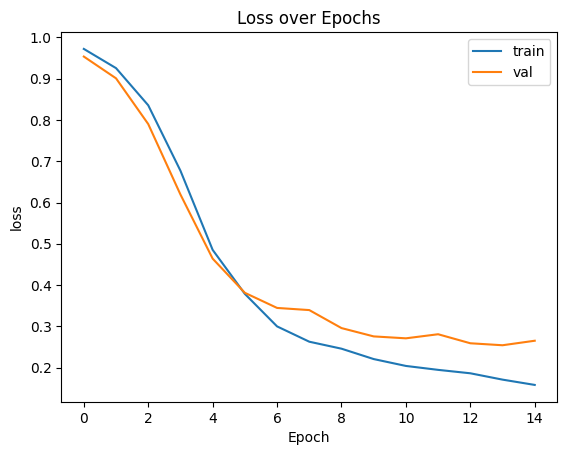

In [83]:
plot_metric(history, 'loss')

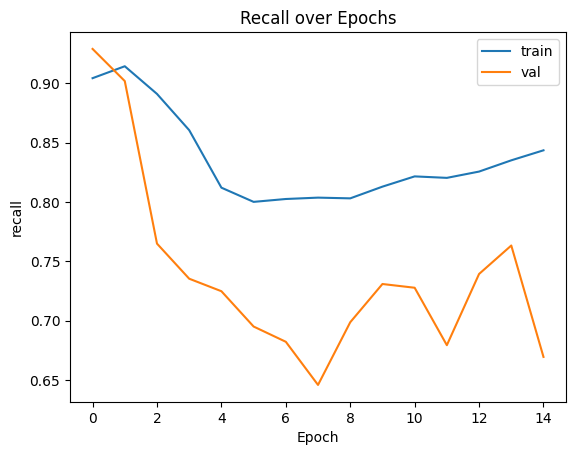

In [84]:
plot_metric(history, 'recall')

In [104]:
torch.save(model, 'ship_segmentation_model_2.pth')

In [89]:
loaded_model = torch.load('ship_segmentation_model_2.pth')

In [92]:
images_to_visualize.shape

torch.Size([5, 768, 768, 3])

torch.Size([768, 768, 3])


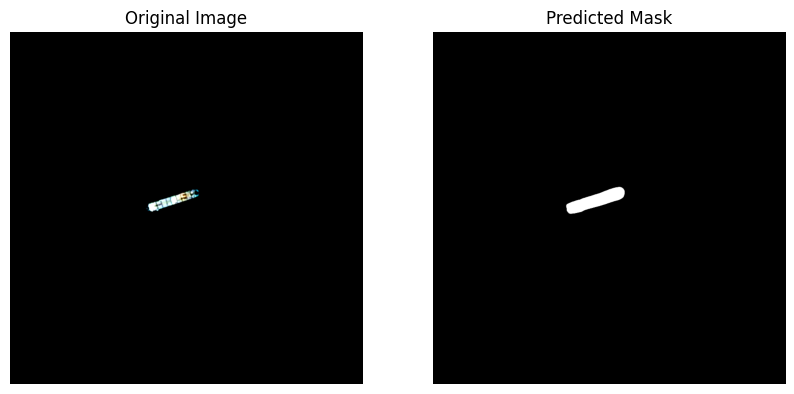

torch.Size([768, 768, 3])


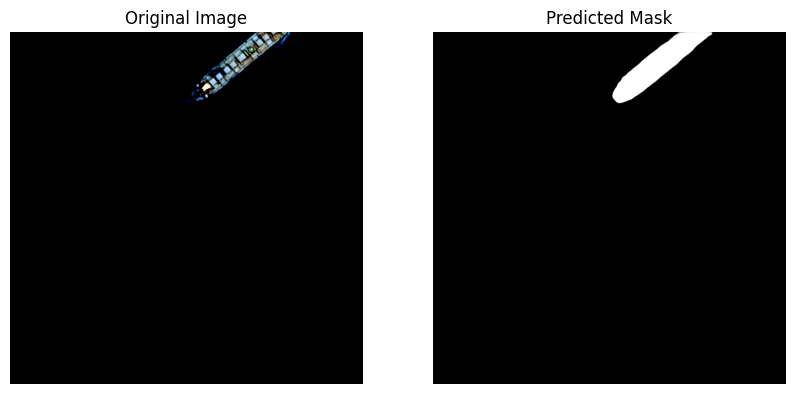

torch.Size([768, 768, 3])


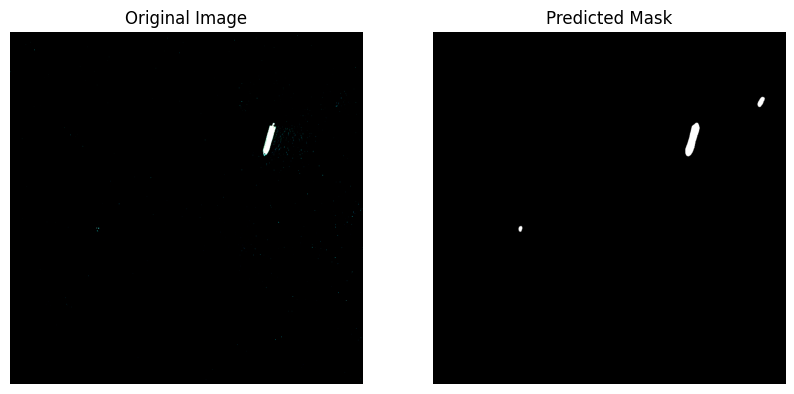

torch.Size([768, 768, 3])


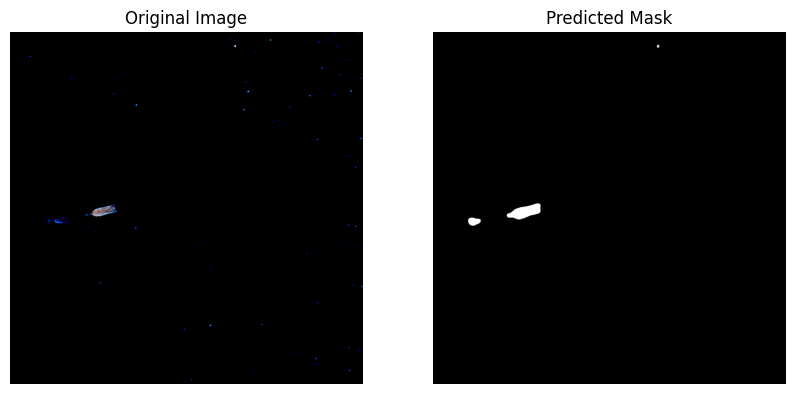

torch.Size([768, 768, 3])


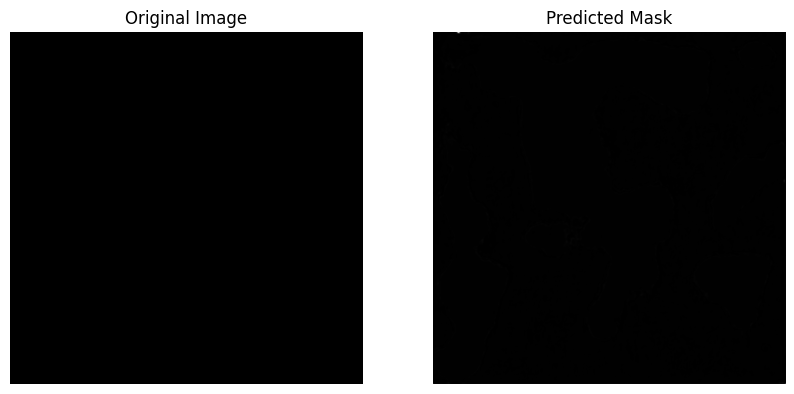

In [102]:
images_batch, _ = next(iter(test_loader))

images_to_visualize = images_batch[:5]

loaded_model.eval()
with torch.no_grad():
    outputs = loaded_model(images_to_visualize.permute(0, 3, 1, 2).to(torch.float32).to(device))


for image, pred in zip(images_to_visualize, outputs):
    plt.figure(figsize=(10, 5))
    print(image.shape)

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.show()